In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import dask
from dask.distributed import Client
from dask import delayed
import metpy.calc as mpcalc
import metpy.units as units
import datetime as dt
import tqdm
import numpy as np
import pandas as pd
from sea_breeze import load_model_data, sea_breeze_funcs

In [2]:
client = Client()
client

2024-12-23 14:51:25,684 - distributed.preloading - INFO - Creating preload: /g/data/hh5/public/apps/dask-optimiser/schedplugin.py
2024-12-23 14:51:25,688 - distributed.utils - INFO - Reload module schedplugin from .py file
2024-12-23 14:51:25,693 - distributed.preloading - INFO - Import preload module: /g/data/hh5/public/apps/dask-optimiser/schedplugin.py
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41977 instead
  warnings.warn(


Modifying workers


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /node/gadi-cpu-bdw-0029.gadi.nci.org.au/24056/proxy/41977/status,
Dashboard: /node/gadi-cpu-bdw-0029.gadi.nci.org.au/24056/proxy/41977/status,Workers: 7
Total threads: 7,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41495,Workers: 7
Dashboard: /node/gadi-cpu-bdw-0029.gadi.nci.org.au/24056/proxy/41977/status,Total threads: 7
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:39775,Total threads: 1
Dashboard: /node/gadi-cpu-bdw-0029.gadi.nci.org.au/24056/proxy/33791/status,Memory: 0 B
Nanny: tcp://127.0.0.1:39879,


In [3]:
# lat_slice=slice(-38,-30)
# lon_slice=slice(112,120)
lon_slice = slice(108,158.5)
lat_slice = slice(-45.7,-6.9)  

exp_id = "mjo-elnino"

t1="2016-01-21 12:00"
t2="2016-01-22 12:00"

# dt_hours=1
# t1_zmla = pd.to_datetime(t1) + dt.timedelta(hours=-dt_hours)
# t2_zmla = pd.to_datetime(t2) + dt.timedelta(hours=dt_hours)

# dx = 0.022
# u_lon_slice=slice(lon_slice.start,lon_slice.stop+dx)
# v_lat_slice=slice(lat_slice.start,lat_slice.stop+dx)  

In [6]:
#Load AUS2200 sfc level data, and static fields (lsm, coastline angles)
# orog, lsm = load_aus2200_static("mjo-elnino",lon_slice,lat_slice)
# aus2200_vas = round_times(load_aus2200_variable(["vas"],t1,t2,"mjo-elnino",lon_slice,v_lat_slice,"10min",chunks="auto")[0], "10min")
# aus2200_uas = round_times(load_aus2200_variable(["uas"],t1,t2,"mjo-elnino",u_lon_slice,lat_slice,"10min",chunks="auto")[0], "10min")
# aus2200_hus = round_times(load_aus2200_variable(["hus"],t1,t2,"mjo-elnino",lon_slice,lat_slice,"10min",chunks="auto")[0], "10min")
# angle_ds = load_angle_ds("/g/data/gb02/ab4502/coastline_data/aus2200_v3.nc",lat_slice,lon_slice)

chunks = {"time":1,"lat":{},"lon":{}}

orog, lsm = load_model_data.load_aus2200_static(
    "mjo-elnino",
    lon_slice,
    lat_slice)
aus2200_vas = load_model_data.round_times(
    load_model_data.load_aus2200_variable(
        "vas",
        t1,
        t2,
        "mjo-elnino",
        lon_slice,
        lat_slice,
        "10min",
        chunks=chunks,
        staggered="lat"),
          "10min")
aus2200_uas = load_model_data.round_times(
    load_model_data.load_aus2200_variable(
        "uas",
        t1,
        t2,
        "mjo-elnino",
        lon_slice,
        lat_slice,
        "10min",
        chunks=chunks,
        staggered="lon"),
          "10min")
aus2200_hus = load_model_data.round_times(
    load_model_data.load_aus2200_variable(
        "hus",
        t1,
        t2,
        "mjo-elnino",
        lon_slice,
        lat_slice,
        "10min",
        chunks=chunks),
          "10min")
aus2200_tas = load_model_data.round_times(
        load_model_data.load_aus2200_variable(
            "tas",
            t1,
            t2,
            "mjo-elnino",
            lon_slice,
            lat_slice,
            "10min",
            chunks=chunks),
            "10min")    
angle_ds = load_model_data.get_coastline_angle_kernel(
    lsm,
    compute=False,
    lat_slice=lat_slice,
    lon_slice=lon_slice,
    path_to_load="/g/data/gb02/ab4502/coastline_data/aus2200.nc")

In [7]:
#Just do the hourly data
aus2200_vas = aus2200_vas.sel(time=aus2200_vas.time.dt.minute==0)
aus2200_uas = aus2200_uas.sel(time=aus2200_uas.time.dt.minute==0)
aus2200_hus = aus2200_hus.sel(time=aus2200_hus.time.dt.minute==0)
aus2200_tas = aus2200_tas.sel(time=aus2200_tas.time.dt.minute==0)

In [8]:
q = aus2200_hus
u = aus2200_uas
v = aus2200_vas
t = aus2200_vas
lat_chunk = "auto"
lon_chunk = "auto"

#Rechunk data in one time dim
q = q.chunk({"time":-1,"lat":lat_chunk,"lon":lon_chunk})
u = u.chunk({"time":-1,"lat":lat_chunk,"lon":lon_chunk})
v = v.chunk({"time":-1,"lat":lat_chunk,"lon":lon_chunk})
t = t.chunk({"time":-1,"lat":lat_chunk,"lon":lon_chunk})

#Convert hus to g/kg 
q = q * 1000

#Define angle of coastline orientation from N
theta=angle_ds.angle_interp 

#Rotate angle to be perpendicular to theta, from E (i.e. mathamatical angle definition)
rotated_angle=(((theta)%360-90)%360) + 90   

#Define normal angle vectors, pointing onshore
cx, cy = [-np.cos(np.deg2rad(rotated_angle)), np.sin(np.deg2rad(rotated_angle))]

#Calculate the wind component perpendicular and parallel to the coast by using the normal unit vectors
vprime = ((u*cx) + (v*cy))

#Calculate the rate of change
wind_change = vprime.differentiate("time",datetime_unit="h")
q_change = q.differentiate("time",datetime_unit="h")
t_change = t.differentiate("time",datetime_unit="h") 

In [32]:

xr.Dataset(
        {"wind_change":wind_change.drop_vars("height"),
         "q_change":q_change,
         "t_change":t_change.drop_vars("height"),
            }).to_netcdf("/scratch/gb02/ab4502/test.nc",engine="netcdf4")

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 76.48 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [29]:
import dask.array as da
#Calculate horizontal moisture gradients
dq_dx = (xr.DataArray(da.gradient(q,axis=q.get_axis_num("lon")), dims=q.dims, coords=q.coords) / dx)
dq_dy = (xr.DataArray(da.gradient(q,axis=q.get_axis_num("lat")), dims=q.dims, coords=q.coords) / dy)        

In [30]:
#Calculate onshore and alongshore wind gradients
dvprime_dx = (xr.DataArray(da.gradient(vprime,axis=q.get_axis_num("lon")), dims=q.dims, coords=q.coords) / dx)
dvprime_dy = (xr.DataArray(da.gradient(vprime,axis=q.get_axis_num("lat")), dims=q.dims, coords=q.coords) / dy)      
duprime_dx = (xr.DataArray(da.gradient(uprime,axis=q.get_axis_num("lon")), dims=q.dims, coords=q.coords) / dx)
duprime_dy = (xr.DataArray(da.gradient(uprime,axis=q.get_axis_num("lat")), dims=q.dims, coords=q.coords) / dy)   

In [31]:
#Rotate gradients to cross shore (c) and along shore (a)
dq_dc = (dq_dx*cx.values) + (dq_dy*cy.values)    
dvprime_dc = (dvprime_dx*cx.values) + (dvprime_dy*cy.values)
duprime_dc = (duprime_dx*cx.values) + (duprime_dy*cy.values)
dq_da = (dq_dx*ax.values) + (dq_dy*ay.values)    

In [32]:
confluence = dq_dc * dvprime_dc
shearing = dq_da * duprime_dc

In [33]:
    out =  xr.Dataset({
        "Fc":xr.DataArray(confluence+shearing,coords=q.coords)
        })


In [34]:
out

<xarray.Dataset> Size: 30GB
Dimensions:  (lat: 1960, lon: 2550, time: 743)
Coordinates:
  * lat      (lat) float64 16kB -45.7 -45.68 -45.66 ... -6.951 -6.931 -6.911
  * lon      (lon) float64 20kB 108.0 108.0 108.1 108.1 ... 158.4 158.5 158.5
  * time     (time) datetime64[ns] 6kB 2016-01-01T01:00:00 ... 2016-01-31T23:...
Data variables:
    Fc       (time, lat, lon) float64 30GB dask.array<chunksize=(1, 1960, 2550), meta=np.ndarray>

In [21]:
out.persist()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 384.08 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


<xarray.Dataset> Size: 30GB
Dimensions:  (lat: 1960, lon: 2550, time: 743)
Coordinates:
  * lat      (lat) float64 16kB -45.7 -45.68 -45.66 ... -6.951 -6.931 -6.911
  * lon      (lon) float64 20kB 108.0 108.0 108.1 108.1 ... 158.4 158.5 158.5
  * time     (time) datetime64[ns] 6kB 2016-01-01T01:00:00 ... 2016-01-31T23:...
Data variables:
    Fc       (time, lat, lon) float64 30GB dask.array<chunksize=(1, 1960, 2550), meta=np.ndarray>

In [22]:
xr.Dataset(
        {"wind_change":wind_change.drop_vars("height"),
         "q_change":q_change,
         "t_change":t_change.drop_vars("height"),
            })

<xarray.Dataset> Size: 59GB
Dimensions:      (lat: 1960, lon: 2550, time: 743)
Coordinates:
  * lat          (lat) float64 16kB -45.7 -45.68 -45.66 ... -6.951 -6.931 -6.911
  * lon          (lon) float64 20kB 108.0 108.0 108.1 ... 158.4 158.5 158.5
  * time         (time) datetime64[ns] 6kB 2016-01-01T01:00:00 ... 2016-01-31...
Data variables:
    wind_change  (time, lat, lon) float64 30GB dask.array<chunksize=(743, 186, 242), meta=np.ndarray>
    q_change     (time, lat, lon) float32 15GB dask.array<chunksize=(743, 186, 242), meta=np.ndarray>
    t_change     (time, lat, lon) float32 15GB dask.array<chunksize=(743, 186, 242), meta=np.ndarray>

In [17]:
#Calculate rate of change in moisture flux
F_dqu = sea_breeze.sea_breeze_funcs.moisture_flux_gradient(
    aus2200_hus,
    aus2200_uas,
    aus2200_vas,
    angle_ds).persist()

In [40]:
#F_dqu_plot = F_dqu.sel(time="2016-01-22 08:00").compute()

In [41]:
# ax=plt.axes(projection=ccrs.PlateCarree())
# F_dqu_plot.plot(cbar_kwargs={"label":"g/kg/m/s$^{2}$"})
# sfc_wind_plot.isel(lat=slice(0,-1,50),lon=slice(0,-1,50)).plot.quiver(x="lon",y="lat",u="u",v="v",scale=500,add_guide=False)
# ax.plot(115.9764, -31.9275, marker="x", color="k")
# ax.coastlines()

In [42]:
# hus_point = aus2200_hus.sel(lat=-31.9275, lon=115.9764, method="nearest").compute()
# uas_point = aus2200_uas.sel(lat=-31.9275, lon=115.9764, method="nearest").compute()

In [43]:
# plt.figure(figsize=[12,4])
# uas_point.sel(time=slice("2016-01-21 12:00", "2016-01-22 12:00")).plot(color="tab:blue",ls="-",label="AUS2200 u-wind")
# obs.sel(station=41,time=slice("2016-01-21 12:00", "2016-01-22 12:00")).u.plot(label="Obs u-wind",ls=":")
# plt.legend()
# plt.gca().twinx()
# hus_point.sel(time=slice("2016-01-21 12:00", "2016-01-22 12:00")).plot(color="tab:purple",label="AUS2200 hus")
# plt.legend(loc="upper center")
# plt.gca().grid(ls=":")
# plt.title("Perth airport")

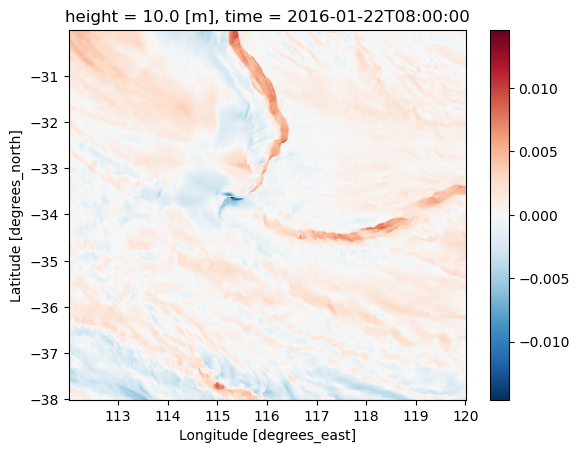

In [30]:
F_dqu.sel(time="2016-01-22 08:00").plot()#.hist(bins=100);

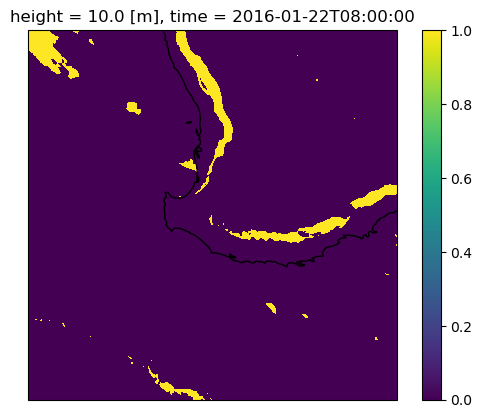

In [18]:
ax=plt.axes(projection=ccrs.PlateCarree())
(F_dqu.sel(time="2016-01-22 08:00") >= 0.003 ).plot()
ax.coastlines()

[ 0  1 22 26 30 32 33]


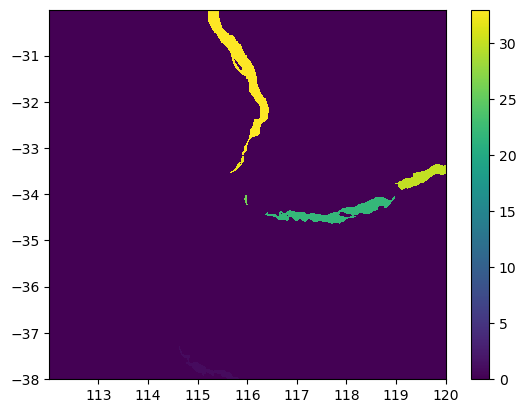

In [55]:
import skimage
import scipy
import tqdm

thresh = 0.003
image = (F_dqu.sel(time="2016-01-22 08:00") >= thresh )

labels = skimage.measure.label(image)
region_props = skimage.measure.regionprops(labels,spacing=(1,1))

labs = np.array([region_props[i].label for i in np.arange(len(region_props))])
eccen = [region_props[i].eccentricity for i in np.arange(len(region_props))]
area = [region_props[i].area for i in np.arange(len(region_props))]
orient = np.rad2deg(np.array([region_props[i].orientation for i in np.arange(len(region_props))]))

angle_tol=20
eccen_thresh=0.95
area_thresh=10

to_remove = labs[(np.array(eccen) < eccen_thresh)].squeeze()
to_remove = list(np.concatenate([to_remove,labs[(np.array(area) < area_thresh)].squeeze()]))

# angle_tol = angle_tol
# for l in tqdm.tqdm(labs):
#     coast_angle = scipy.stats.circmean(angle_ds.where(labels==l,np.nan).angle_interp,nan_policy="omit",low=-90,high=90)
#     if np.abs(coast_angle - orient[labs==l][0]) > angle_tol:
#         to_remove.append(l)

to_remove = np.unique(to_remove)

for i in to_remove:
    labels[labels==i] = 0

x,y=np.meshgrid(F_dqu.lon,F_dqu.lat)

plt.pcolormesh(x,y,labels); plt.colorbar()
print((np.unique(labels)))


In [27]:
l=33
angle_ds_arr = angle_ds.angle_interp.values
#scipy.stats.circmean(np.where(labels==l,np.nan),nan_policy="omit",low=-90,high=90)
coast_angles = [scipy.stats.circmean(angle_ds_arr[labels==l],low=-90,high=90) for l in tqdm.tqdm(labs)]

100%|██████████| 8266/8266 [00:24<00:00, 338.80it/s]


In [83]:
coords = [region_props[i].coords for i in np.arange(len(region_props))]
[coords[i][:,0] for i in range(len(coords))]
#coords[0][:,0]

43

In [126]:
def circmean(angle_ds,low,high):
    return scipy.stats.circmean(angle_ds,low=low,high=high)

# beta = xr.apply_ufunc(
#         circmean,
#         angle_ds.angle_interp.groupby(label_da),
#         -90,
#         90,
#         dask="parallelized",  # Ensures Dask compatibility
#         output_dtypes=[float],  # Specify output dtype
#     ) 

angle_ds.angle_interp.groupby(label_da).apply(circmean,(-90,90)

100%|██████████| 7/7 [00:00<00:00, 10.01it/s]


In [131]:
def circmean(angle_ds):
    return scipy.stats.circmean(angle_ds.values,low=-90,high=90)

label_da = xr.DataArray(data=labels,dims=["lon","lat"],coords={"lat":aus2200_uas.lat,"lon":aus2200_uas.lon})
angle_ds.angle_interp.groupby(label_da).apply(circmean)

AttributeError: 'numpy.float64' object has no attribute 'dims'

In [232]:
l=2
coast_angle = scipy.stats.circmean(angle_ds.where(labels==l,np.nan).angle_interp,nan_policy="omit",low=-90,high=90)
print(coast_angle,orient[labs==l][0])
np.abs(coast_angle - orient[labs==l][0]) > angle_tol

nan 45.0


/jobfs/130158816.gadi-pbs/ipykernel_4107033/2861917334.py:2: SmallSampleWarning: After omitting NaNs, one or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  coast_angle = scipy.stats.circmean(angle_ds.where(labels==l,np.nan).angle_interp,nan_policy="omit",low=-90,high=90)


False

In [236]:
(labels==l)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [214]:
np.unique(labels)

array([ 0,  1, 22, 30, 33, 38], dtype=int32)

In [215]:
#0 = vertical
#90 = horizontal
#-90 = horizontal

orient = [region_props[i].orientation for i in np.arange(len(region_props))]

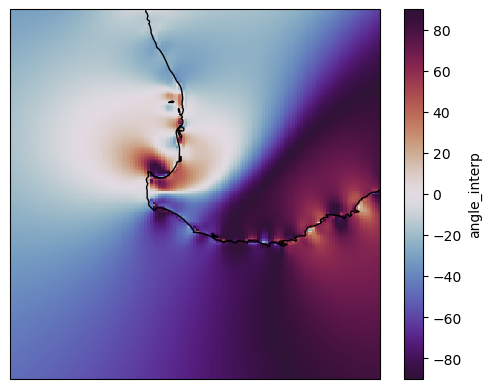

In [216]:
ax=plt.axes(projection=ccrs.PlateCarree())
((angle_ds.angle_interp-90) % 180 - 90).plot(cmap="twilight_shifted",ax=ax,vmin=-90,vmax=90)
ax.coastlines()

In [217]:
import scipy
l = 33
print("Avg coast angle",scipy.stats.circmean(angle_ds.where(labels==l,np.nan).angle_interp,nan_policy="omit",low=-90,high=90))
print("Object orientation",np.rad2deg(np.array(orient)[np.array(labs==l)]))

Avg coast angle -17.74536247536051
Object orientation [-20.55611447]


In [14]:
#Rechunk everything one latlon chunk, as we are now calculating horizontal gradients
F_latlon_chunk = -1
F_time_chunk = 1
aus2200_hus = aus2200_hus.chunk({"time":F_time_chunk,"lat":F_latlon_chunk,"lon":F_latlon_chunk})
aus2200_uas = aus2200_uas.chunk({"time":F_time_chunk,"lat":F_latlon_chunk,"lon":F_latlon_chunk})
aus2200_vas = aus2200_vas.chunk({"time":F_time_chunk,"lat":F_latlon_chunk,"lon":F_latlon_chunk})

In [15]:
#Calculate frontogenesis
Fq = kinematic_frontogenesis(
    aus2200_hus,
    aus2200_uas,
    aus2200_vas)

In [16]:
#Calculate coast-relative frontogensis
Fc = coast_relative_frontogenesis(
    aus2200_hus,
    aus2200_uas,
    aus2200_vas, angle_ds)

In [17]:
Fq_plot = Fq.sel(time="2016-01-22 08:00").compute()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 77.31 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [18]:
Fc_plot = Fc.sel(time="2016-01-22 08:00").compute()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 231.51 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [5]:
#Load model level wind data for the sea breeze index
aus2200_ua = load_aus2200_variable(["ua"],t1,t2,"mjo-elnino",u_lon_slice,lat_slice,"1hr",hgt_slice=slice(0,5000),chunks="auto")[0]
aus2200_va = load_aus2200_variable(["va"],t1,t2,"mjo-elnino",lon_slice,v_lat_slice,"1hr",hgt_slice=slice(0,5000),chunks="auto")[0]

In [6]:
#Destagger by centering v wind in lat and u wind in lon
aus2200_va = (aus2200_va.isel(lat=slice(0,-1)).assign_coords({"lat":lsm.lat}) +
                aus2200_va.isel(lat=slice(1,aus2200_va.lat.shape[0])).assign_coords({"lat":lsm.lat})) / 2
aus2200_ua = (aus2200_ua.isel(lon=slice(0,-1)).assign_coords({"lon":lsm.lon}) +
                aus2200_ua.isel(lon=slice(1,aus2200_ua.lon.shape[0])).assign_coords({"lon":lsm.lon})) / 2
aus2200_wind = xr.Dataset({"u":aus2200_ua, "v":aus2200_va})

In [7]:
aus2200_zmla = load_aus2200_variable(["zmla"],t1_zmla,t2_zmla,"mjo-elnino",lon_slice,lat_slice,"1hr",chunks="auto")[0]

In [8]:
aus2200_zmla = (aus2200_zmla.isel(time=slice(0,-1)).assign_coords({"time":aus2200_ua.time}) +
                aus2200_zmla.isel(time=slice(1,aus2200_zmla.time.shape[0])).assign_coords({"time":aus2200_ua.time})) / 2

In [13]:
def daily_mean_wind(wind_ds):

    """
    For an xarray dataset with u and v winds, take a rolling daily mean
    """

    dt_h = np.round((wind_ds.time.diff("time")[0].values / (1e9 * 60 * 60)).astype(float)).astype(int)
    time_window = int(24 / dt_h)
    min_periods = int(time_window/2)

    u_mean = wind_ds["u"].rolling(dim={"time":time_window},center=True,min_periods=min_periods).mean()
    v_mean = wind_ds["v"].rolling(dim={"time":time_window},center=True,min_periods=min_periods).mean()

    return u_mean, v_mean
    
u_mean, v_mean = daily_mean_wind(aus2200_wind)
    
#wind_ds["u"] = wind_ds["u"] - u_mean
#wind_ds["v"] = wind_ds["v"] - v_mean

In [ ]:
u_mean.to_netcdf("/scratch/gb02/ab4502/tmp/u_mean.nc")

2024-11-29 12:20:24,661 - distributed.worker.memory - WARNING - Worker is at 84% memory usage. Pausing worker.  Process memory: 3.79 GiB -- Worker memory limit: 4.50 GiB
2024-11-29 12:20:25,278 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 3.59 GiB -- Worker memory limit: 4.50 GiB
2024-11-29 12:21:00,027 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.61 GiB -- Worker memory limit: 4.50 GiB
2024-11-29 12:21:00,134 - distributed.worker.memory - WARNING - Worker is at 63% memory usage. Resuming worker. Process memory: 2.85 GiB -- Worker memory limit: 4.50 GiB
2024-11-29 12:21:15,503 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.68 GiB -- Worker memory limit: 4.50 GiB
2024-11-29 12:21:15,505 - distributed.worker.memory - WARNING - Worker is at 72% memory usage. Resuming worker. Process memory: 3.28 GiB -- Worker mem

In [23]:
#Compute SBI with unified chunks
sbi_time_chunks = 1
sbi_latlon_chunks = 50
sbi_lev_chunks = -1


sbi = calc_sbi(aus2200_wind.rename({"lev":"height"}),
                            angle_ds,
                            subtract_mean=False,
                            height_mean=False,
                            height_method="blh",
                            blh_da=aus2200_zmla,
                            alpha_height=0)

In [24]:
sbi_plot = sbi.sel(time="2016-01-22 08:00").compute()

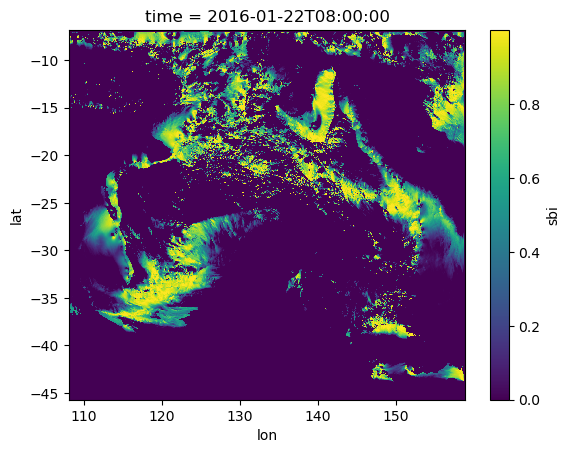

In [26]:
sbi_plot.sbi.plot()

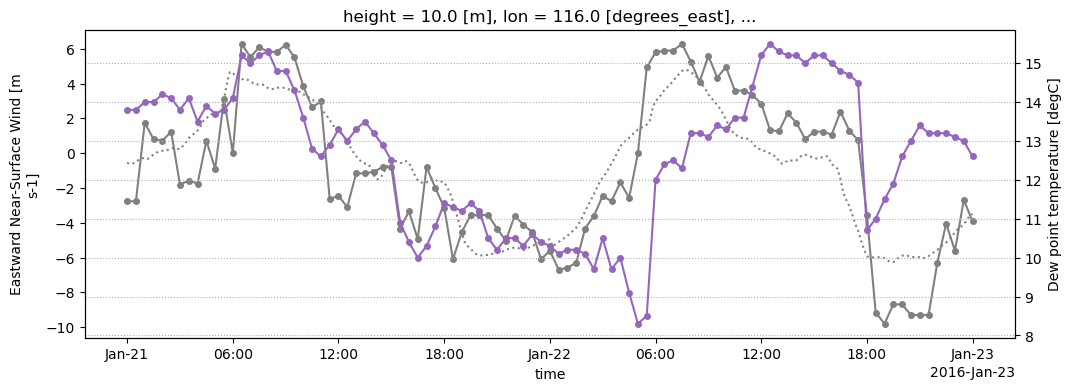

In [19]:
plt.figure(figsize=[12,4])

uax = plt.axes()
obs.sel(station=41).u.plot(ax=uax,marker="o",ms=4,color="grey")
tax = uax.twinx()
obs.sel(station=41).Tdew.plot(ax=tax,color="tab:purple",marker="o",ms=4)
tax.grid(ls=":")


aus2200_sfc_wind["u"]\
    .sel(lat=obs.sel(station=41).lati.values,
        lon=obs.sel(station=41).long.values,method="nearest")\
    .plot(ax=uax,marker="none",ms=4,color="grey",ls=":")


In [ ]:
t = "2016-01-22 08:00"

plt.figure(figsize=[12,10])
# ax = plt.subplot(2,2,1,projection=ccrs.PlateCarree())
# print("Calculating moisture flux gradient")
# F_dqu.sel(time=t).plot()

# ax = plt.subplot(2,2,2,projection=ccrs.PlateCarree())
# print("Calculating frontogenesis")
# Fq.sel(time=t).plot()

# ax = plt.subplot(2,2,3,projection=ccrs.PlateCarree())
# print("Calculating coast-relative frontogenesis")
# Fc.total.sel(time=t).plot()

ax = plt.subplot(2,2,4,projection=ccrs.PlateCarree())
print("Calculating SBI")
sbi.sbi.sel(time=t).plot()

Calculating SBI


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 120.89 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [ ]:
moisture_flux_gradient(
    obs["hus"],obs["u"],obs["v"],angle_ds.sel(
        lat=obs.sel(station=41).lati.values,
        lon=obs.sel(station=41).long.values,method="nearest")
).sel(station=41).plot()

F_dqu.sel(lat=obs.sel(station=41).lati.values,lon=obs.sel(station=41).long.values,method="nearest").plot()

plt.gca().grid(ls=":")
#plt.ylim([-0.1,0.1])

Text(0.5, 1.0, '2d kinematic frontogenesis parameter')

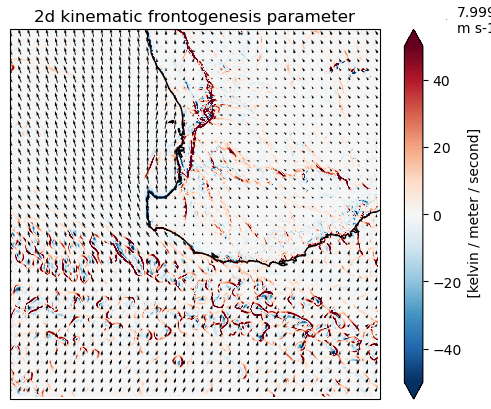

In [13]:
t = "2016-01-21 12:10"

ax = plt.axes(projection=ccrs.PlateCarree())
Fq.sel(time=t).plot(cmap="RdBu_r",vmin=-50,vmax=50)
aus2200_sfc_wind.sel(time=t).squeeze().isel(lat=slice(0,-1,10),lon=slice(0,-1,10)).\
    plot.quiver(x="lon",y="lat",u="u",v="v")
ax.coastlines()

plt.title("2d kinematic frontogenesis parameter")

In [14]:
!rm /g/data/gb02/ab4502/figs/sea_breeze/*.png
cnt=1
for t in tqdm.tqdm([dt.datetime.strptime("2016-01-21 12:00","%Y-%m-%d %H:%M") + dt.timedelta(minutes=i*10) for i in range(0,aus2200_sfc["vas"].time.shape[0]) ]):
    plt.figure(figsize=[14,10])
    ax = plt.axes(projection=ccrs.PlateCarree())

    Fq.sel(time=t,method="nearest").plot(cmap="RdBu_r",vmin=-50,vmax=50,cbar_kwargs={"label": Fq.units.values})
    aus2200_sfc_wind.sel(time=t).squeeze().isel(lat=slice(0,-1,10),lon=slice(0,-1,10)).\
        plot.quiver(x="lon",y="lat",u="u",v="v",scale=500)
    ax.coastlines()
    plt.savefig("/g/data/gb02/ab4502/figs/sea_breeze/"+t.strftime("%Y%m%d%H%M")+".png")
    plt.close()
    cnt=cnt+1

100%|██████████| 145/145 [01:33<00:00,  1.55it/s]


In [15]:
Fc = coast_relative_frontogenesis(aus2200_sfc["hus"]["hus"], aus2200_sfc["uas"]["uas"], aus2200_sfc["vas"]["vas"], angle_ds)

Text(0.5, 1.0, 'Coast-relative moisture frontogenesis')

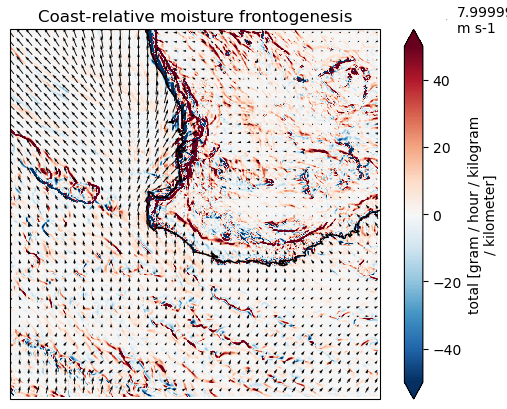

In [16]:
t = "2016-01-22 06:10"

ax = plt.axes(projection=ccrs.PlateCarree())
(Fc["total"]).sel(time=t).plot(cmap="RdBu_r",vmin=-50,vmax=50)
aus2200_sfc_wind.sel(time=t).squeeze().isel(lat=slice(0,-1,10),lon=slice(0,-1,10)).\
    plot.quiver(x="lon",y="lat",u="u",v="v")
ax.coastlines()

plt.title("Coast-relative moisture frontogenesis")

In [17]:
!rm /g/data/gb02/ab4502/figs/sea_breeze/*.png
cnt=1
for t in tqdm.tqdm([dt.datetime.strptime("2016-01-21 12:00","%Y-%m-%d %H:%M") + dt.timedelta(minutes=i*10) for i in range(0,aus2200_sfc["vas"].time.shape[0]) ]):
    plt.figure(figsize=[14,10])
    ax = plt.axes(projection=ccrs.PlateCarree())

    Fc.total.sel(time=t,method="nearest").plot(cmap="RdBu_r",vmin=-50,vmax=50,cbar_kwargs={"label": Fq.units.values})
    aus2200_sfc_wind.sel(time=t).squeeze().isel(lat=slice(0,-1,10),lon=slice(0,-1,10)).\
        plot.quiver(x="lon",y="lat",u="u",v="v",scale=500)
    ax.coastlines()
    plt.savefig("/g/data/gb02/ab4502/figs/sea_breeze/"+t.strftime("%Y%m%d%H%M")+".png")
    plt.close()
    cnt=cnt+1

100%|██████████| 145/145 [01:36<00:00,  1.51it/s]


In [17]:


# F_dudt_dqdt = calc_dudt_dqdt(
#     aus2200_sfc["hus"]["hus"].chunk({"time":-1,"lat":100,"lon":100}).compute(),
#     aus2200_sfc["uas"]["uas"].chunk({"time":-1,"lat":100,"lon":100}).compute(),
#     aus2200_sfc["vas"]["vas"].chunk({"time":-1,"lat":100,"lon":100}).compute(),
#     angle_ds)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 361.13 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 451.41 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 631.96 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 631.96 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Text(0.5, 1.0, 'Rate of change in local moisture flux')

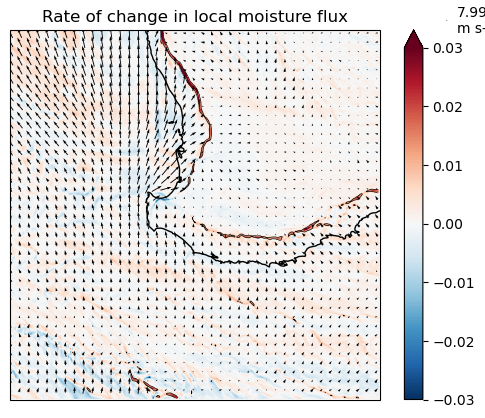

In [19]:
t = "2016-01-22 08:00"
thresh = 0.01

ax = plt.axes(projection=ccrs.PlateCarree())
F_qa.sel(time=t).plot(cmap="RdBu_r",vmin=-.030,vmax=.030)
xr.plot.contour(F_qa.sel(time=t),levels=[thresh],colors="k",linewidths=0.5)
aus2200_sfc_wind.sel(time=t).squeeze().isel(lat=slice(0,-1,10),lon=slice(0,-1,10)).\
    plot.quiver(x="lon",y="lat",u="u",v="v")
ax.coastlines()

plt.title("Rate of change in local moisture flux")

Text(0.5, 1.0, 'Rate of change in local moisture flux')

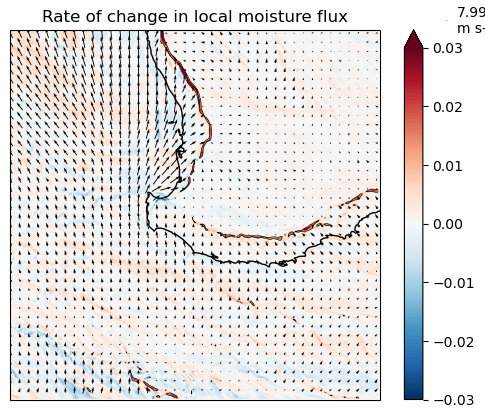

In [18]:
t = "2016-01-22 08:00"
thresh = 0.01

ax = plt.axes(projection=ccrs.PlateCarree())
F_dqu.sel(time=t).plot(cmap="RdBu_r",vmin=-.030,vmax=.030)
xr.plot.contour(F_dqu.sel(time=t),levels=[thresh],colors="k",linewidths=0.5)
aus2200_sfc_wind.sel(time=t).squeeze().isel(lat=slice(0,-1,10),lon=slice(0,-1,10)).\
    plot.quiver(x="lon",y="lat",u="u",v="v")
ax.coastlines()

plt.title("Rate of change in local moisture flux")

In [25]:
!rm /g/data/gb02/ab4502/figs/sea_breeze/*.png
cnt=1
for t in tqdm.tqdm([dt.datetime.strptime("2016-01-21 12:00","%Y-%m-%d %H:%M") + dt.timedelta(minutes=i*10) for i in range(0,aus2200_sfc["vas"].time.shape[0]) ]):
    plt.figure(figsize=[14,10])
    ax = plt.axes(projection=ccrs.PlateCarree())

    F_qa.sel(time=t,method="nearest").plot(cmap="RdBu_r",vmin=-.030,vmax=.030)
    aus2200_sfc_wind.sel(time=t).squeeze().isel(lat=slice(0,-1,10),lon=slice(0,-1,10)).\
        plot.quiver(x="lon",y="lat",u="u",v="v",scale=500)
    ax.coastlines()
    plt.savefig("/g/data/gb02/ab4502/figs/sea_breeze/"+t.strftime("%Y%m%d%H%M")+".png")
    plt.close()
    cnt=cnt+1

rm: cannot remove '/g/data/gb02/ab4502/figs/sea_breeze/*.png': No such file or directory


100%|██████████| 145/145 [01:36<00:00,  1.51it/s]


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 109.90 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Text(0.5, 1.0, 'Sea breeze index')

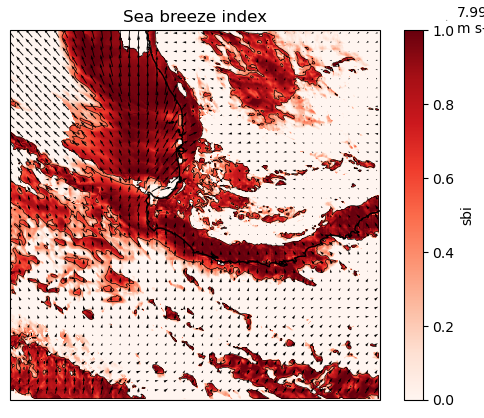

In [14]:
t = "2016-01-22 06:00"
thresh = 0.5

ax = plt.axes(projection=ccrs.PlateCarree())
sbi.sbi.sel(time=t).plot(cmap="Reds",vmin=0,vmax=1)
xr.plot.contour(sbi.sbi.sel(time=t),levels=[thresh],colors="k",linewidths=0.5)
aus2200_sfc_wind.sel(time=t).squeeze().isel(lat=slice(0,-1,10),lon=slice(0,-1,10)).\
    plot.quiver(x="lon",y="lat",u="u",v="v")
ax.coastlines()

plt.title("Sea breeze index")

In [15]:
!rm /g/data/gb02/ab4502/figs/sea_breeze/*.png
cnt=1
for t in tqdm.tqdm([dt.datetime.strptime("2016-01-21 12:00","%Y-%m-%d %H:%M") + dt.timedelta(hours=i) for i in range(0,sbi.time.shape[0]) ]):
    plt.figure(figsize=[14,10])
    ax = plt.axes(projection=ccrs.PlateCarree())

    sbi.sbi.sel(time=t).plot(cmap="Reds",vmin=0,vmax=1)
    aus2200_sfc_wind.sel(time=t).squeeze().isel(lat=slice(0,-1,10),lon=slice(0,-1,10)).\
        plot.quiver(x="lon",y="lat",u="u",v="v",scale=500)
    ax.coastlines()
    plt.savefig("/g/data/gb02/ab4502/figs/sea_breeze/"+t.strftime("%Y%m%d%H%M")+".png")
    plt.close()
    cnt=cnt+1

100%|██████████| 25/25 [00:15<00:00,  1.59it/s]


In [ ]:
v = aus2200_sfc["uas"]["uas"]
q = aus2200_sfc["hus"]["hus"]
v.sel(lat=-33,lon=116,method="nearest").plot(color="tab:red")
plt.gca().twinx()
q.sel(lat=-33,lon=116,method="nearest").plot(color="tab:blue")

In [50]:
import xarray as xr
import metpy
import metpy.calc as mpcalc

def load_half_hourly_stn_obs(state,time_slice):

    '''
    Load half-hourly AWS data and slice based on time. Also convert wind speed and direction to 
    u and v wind components

    state = str, one of "NSW-ACT", "NT", "QLD", "SA", "TAS-ANT", "VIC", "WA"
    time_slice = slice of strings ("%Y-%m-%d %H:%M", "%Y-%m-%d %H:%M")
    '''

    path = "/g/data/w40/clv563/BoM_data_202409/half_hourly_data_netcdf/"
    stn_obs = xr.open_dataset(path + "AWS-data-" + state + ".nc").sel(time=time_slice)
    u,v = metpy.calc.wind_components(
    stn_obs.wspd.metpy.convert_units("m/s"),
    stn_obs.wdir * metpy.units.units.deg)
    stn_obs["u"] = u
    stn_obs["v"] = v

    stn_obs["Tdew"] = stn_obs["Tdew"].assign_attrs(units = "degC")
    stn_obs["hus"] = mpcalc.specific_humidity_from_dewpoint(stn_obs["mslp"],stn_obs["Tdew"])

    return stn_obs

obs = load_half_hourly_stn_obs("WA",slice(t1,t2))

(-0.02, 0.02)

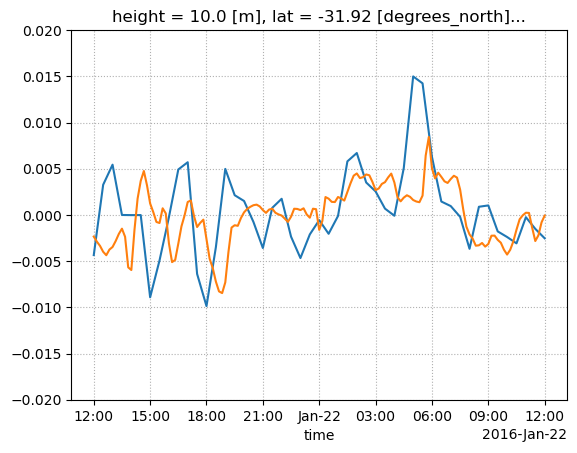

In [65]:
moisture_advection(obs["hus"],obs["u"],obs["v"],angle_ds.sel(lat=obs.sel(station=41).lati.values,
                                                            lon=obs.sel(station=41).long.values,method="nearest") ).sel(station=41).plot()

F_dqu.sel(lat=obs.sel(station=41).lati.values,lon=obs.sel(station=41).long.values,method="nearest").plot()

plt.gca().grid(ls=":")
plt.ylim([-0.02,0.02])